In [1]:
# # 04 - Supervised Learning
# ## Classification Models for Heart Disease Prediction
# 
# ### Objectives:
# - Train Logistic Regression, Decision Tree, Random Forest, SVM
# - Evaluate models using multiple metrics
# - Compare performance with different feature sets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve)
import joblib

In [5]:
# Load data
X_clean = pd.read_csv('data/heart_disease_cleaned_features.csv')
X_selected = pd.read_csv('data/heart_disease_selected_features.csv')
y_clean = pd.read_csv('data/heart_disease_cleaned_target.csv')['target']

print("Data loaded successfully!")

Data loaded successfully!


In [7]:
def train_evaluate_models(X, y, feature_set_name="All Features"):
    """Train and evaluate multiple classification models"""
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    results = {}
    
    print(f"Training models with {feature_set_name}...")
    print("=" * 60)
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"  {name:20} | Accuracy: {accuracy:.3f} | AUC: {auc:.3f}")
    
    return results, X_test, y_test

In [9]:
# Train models with all features
results_all, X_test_all, y_test_all = train_evaluate_models(X_clean, y_clean, "All Features")

Training models with All Features...
Training Logistic Regression...
  Logistic Regression  | Accuracy: 0.869 | AUC: 0.951
Training Decision Tree...
  Decision Tree        | Accuracy: 0.721 | AUC: 0.729
Training Random Forest...
  Random Forest        | Accuracy: 0.902 | AUC: 0.951
Training SVM...
  SVM                  | Accuracy: 0.820 | AUC: 0.920


In [11]:
# Train models with selected features
results_selected, X_test_selected, y_test_selected = train_evaluate_models(X_selected, y_clean, "Selected Features")

Training models with Selected Features...
Training Logistic Regression...
  Logistic Regression  | Accuracy: 0.852 | AUC: 0.935
Training Decision Tree...
  Decision Tree        | Accuracy: 0.754 | AUC: 0.762
Training Random Forest...
  Random Forest        | Accuracy: 0.852 | AUC: 0.933
Training SVM...
  SVM                  | Accuracy: 0.820 | AUC: 0.925


In [13]:
def visualize_model_comparison(results_all, results_selected):
    """Compare model performance with different feature sets"""
    
    # Create comparison dataframe
    comparison_data = []
    
    for model_name in results_all.keys():
        comparison_data.append({
            'Model': model_name,
            'Feature Set': 'All Features',
            'Accuracy': results_all[model_name]['accuracy'],
            'Precision': results_all[model_name]['precision'],
            'Recall': results_all[model_name]['recall'],
            'F1-Score': results_all[model_name]['f1'],
            'AUC': results_all[model_name]['auc']
        })
        
        comparison_data.append({
            'Model': model_name,
            'Feature Set': 'Selected Features',
            'Accuracy': results_selected[model_name]['accuracy'],
            'Precision': results_selected[model_name]['precision'],
            'Recall': results_selected[model_name]['recall'],
            'F1-Score': results_selected[model_name]['f1'],
            'AUC': results_selected[model_name]['auc']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    
    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        pivot_data = comparison_df.pivot(index='Model', columns='Feature Set', values=metric)
        
        x = np.arange(len(pivot_data.index))
        width = 0.35
        
        axes[row, col].bar(x - width/2, pivot_data['All Features'], width, 
                          label='All Features', alpha=0.7)
        axes[row, col].bar(x + width/2, pivot_data['Selected Features'], width, 
                          label='Selected Features', alpha=0.7)
        
        axes[row, col].set_title(f'{metric} Comparison')
        axes[row, col].set_xlabel('Model')
        axes[row, col].set_ylabel(metric)
        axes[row, col].set_xticks(x)
        axes[row, col].set_xticklabels(pivot_data.index, rotation=45)
        axes[row, col].legend()
        axes[row, col].grid(alpha=0.3)
        
        # Add value labels
        for j, v in enumerate(pivot_data['All Features']):
            axes[row, col].text(j - width/2, v + 0.01, f'{v:.3f}', 
                               ha='center', va='bottom', fontsize=8)
        for j, v in enumerate(pivot_data['Selected Features']):
            axes[row, col].text(j + width/2, v + 0.01, f'{v:.3f}', 
                               ha='center', va='bottom', fontsize=8)
    
    # ROC Curves
    axes[1, 2].clear()
    for model_name, result in results_selected.items():
        fpr, tpr, _ = roc_curve(y_test_selected, result['y_pred_proba'])
        axes[1, 2].plot(fpr, tpr, label=f'{model_name} (AUC = {result["auc"]:.3f})')
    
    axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, 2].set_xlabel('False Positive Rate')
    axes[1, 2].set_ylabel('True Positive Rate')
    axes[1, 2].set_title('ROC Curves (Selected Features)')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

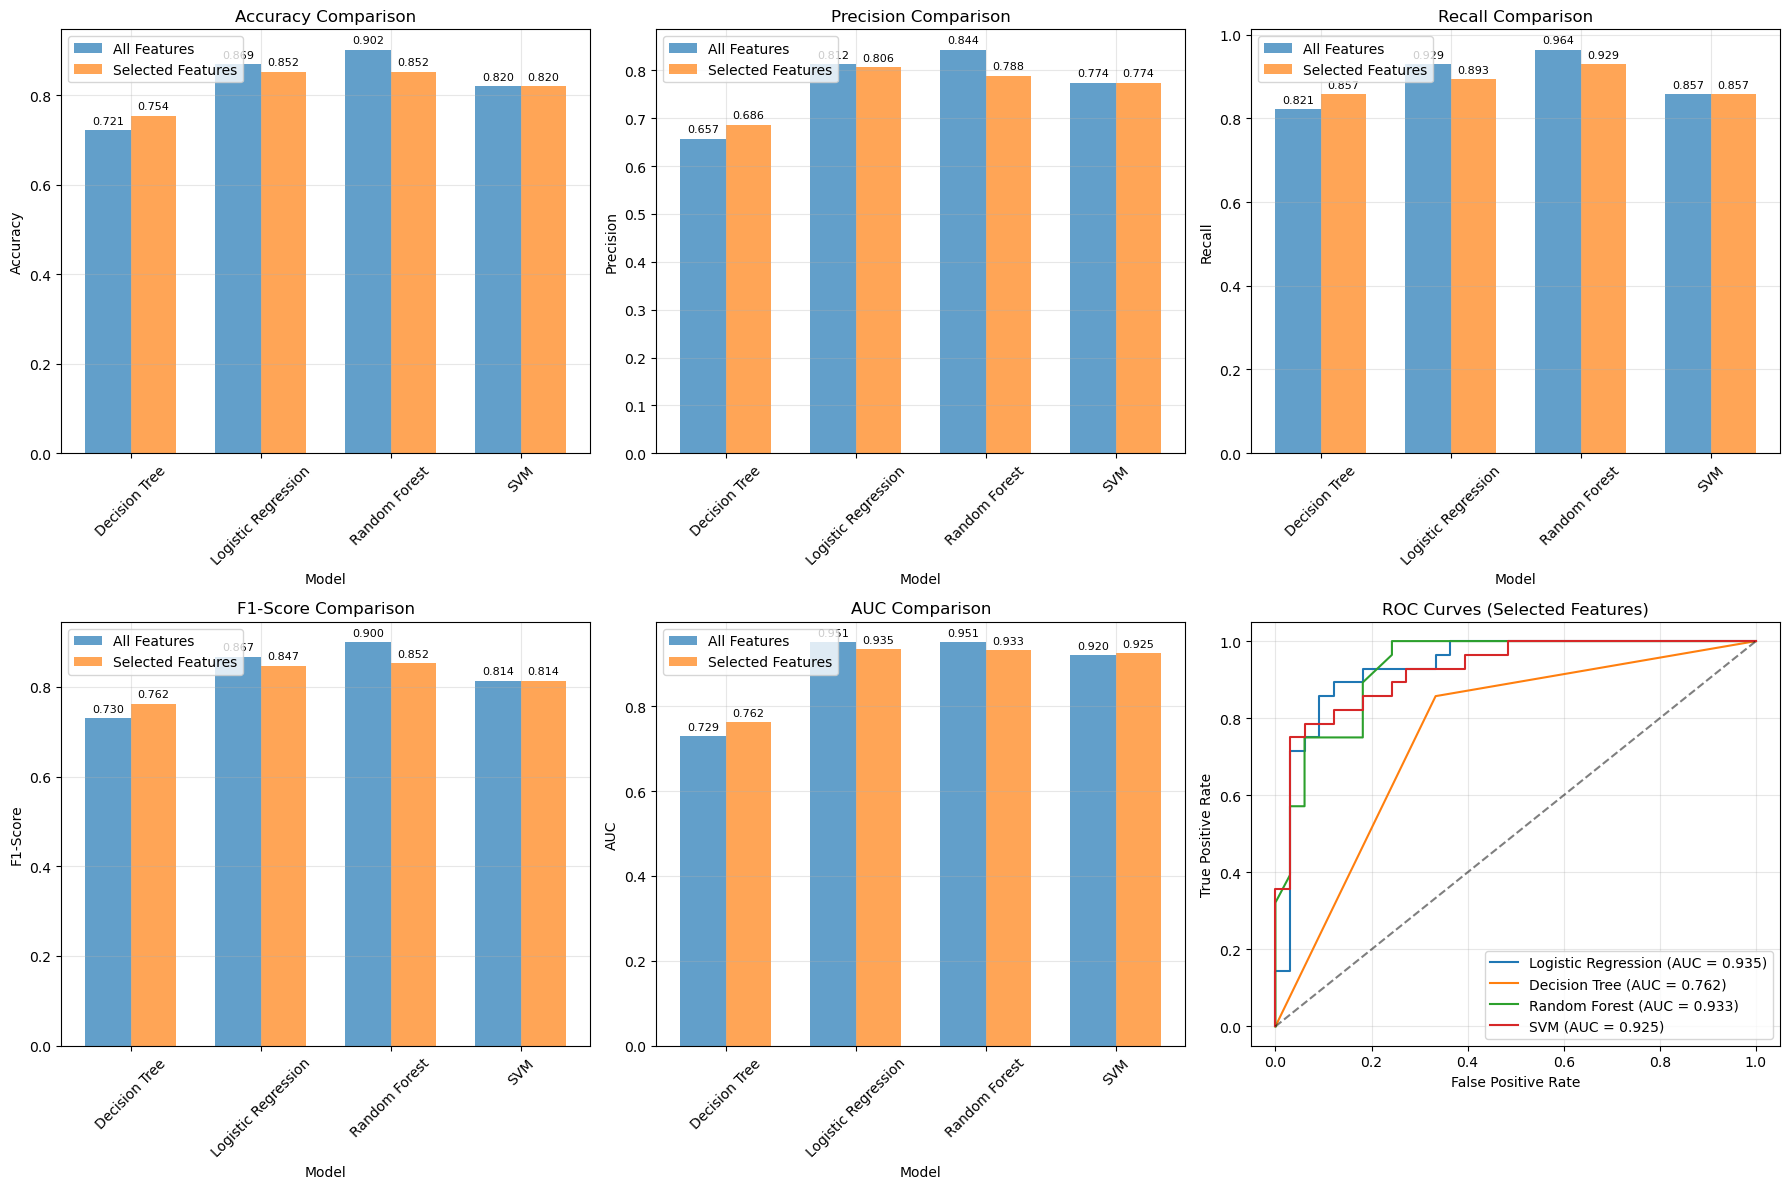

In [15]:
# Compare model performance
comparison_df = visualize_model_comparison(results_all, results_selected)

In [17]:
def detailed_model_analysis(results, X_test, y_test, feature_set_name):
    """Detailed analysis for each model"""
    
    print(f"\nDetailed Model Analysis - {feature_set_name}")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, (model_name, result) in enumerate(results.items()):
        # Confusion Matrix
        cm = confusion_matrix(y_test, result['y_pred'])
        
        axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[i].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.3f}')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                axes[i].text(k, j, format(cm[j, k], 'd'),
                           ha="center", va="center",
                           color="white" if cm[j, k] > thresh else "black")
        
        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(['No Disease', 'Disease'])
        axes[i].set_yticklabels(['No Disease', 'Disease'])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        
        # Print classification report
        print(f"\n{model_name} - Classification Report:")
        print(classification_report(y_test, result['y_pred']))
    
    plt.tight_layout()
    plt.show()


Detailed Model Analysis - Selected Features

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.81      0.89      0.85        28

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61


Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        33
           1       0.69      0.86      0.76        28

    accuracy                           0.75        61
   macro avg       0.77      0.76      0.75        61
weighted avg       0.77      0.75      0.75        61


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accurac

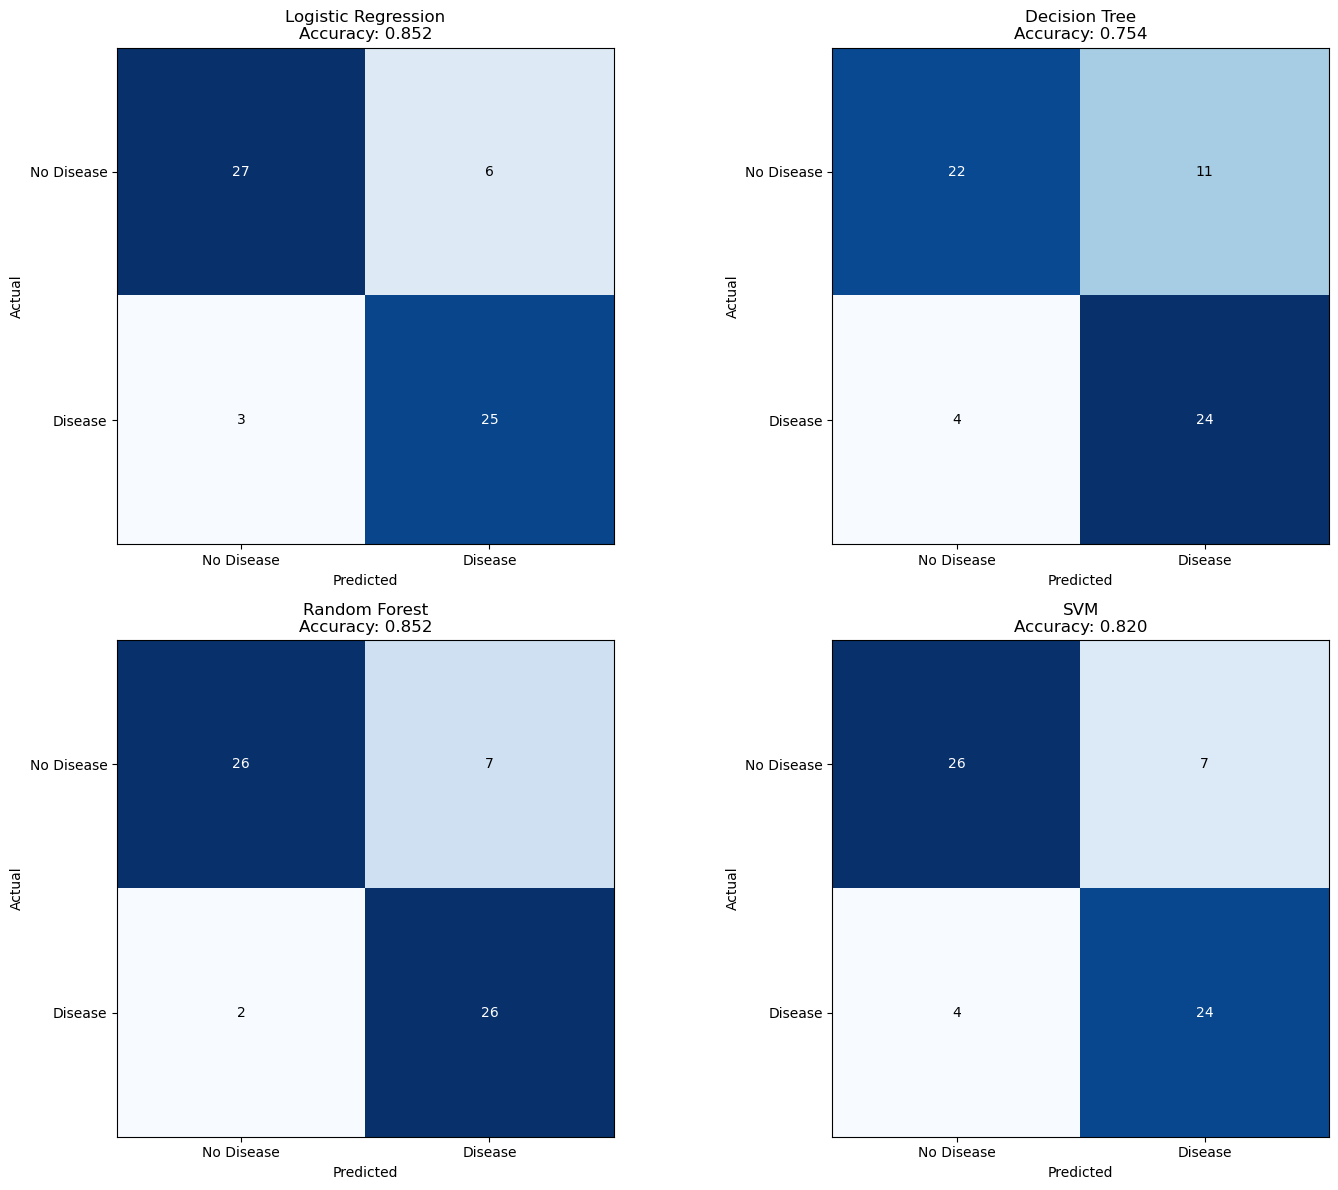

In [19]:
# Detailed analysis for selected features
detailed_model_analysis(results_selected, X_test_selected, y_test_selected, "Selected Features")

In [21]:
# Save the best model (Random Forest typically performs well)
best_model_name = max(results_selected.items(), 
                     key=lambda x: x[1]['accuracy'])[0]
best_model = results_selected[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Accuracy: {results_selected[best_model_name]['accuracy']:.3f}")


Best performing model: Logistic Regression
Accuracy: 0.852


In [25]:
# Save the best model
joblib.dump(best_model, 'models/Supervised_learning_Logistic_Regression_best_model.pkl')
joblib.dump(results_selected, 'models/all_models_results.pkl')

print("\nSupervised learning completed! Models saved.")


Supervised learning completed! Models saved.
